# Capstone Vinci - Contour detection

# How to ?

1. [Load the clean data](#1-how-to-load-the-clean-data-segments-)
1. [Plot the plan](#2-how-to-plot-the-plan-in-hd-)
1. [Iterate through the segments](#3-how-to-iterate-through-the-segments)

In [38]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt
import utils.parse_geojson as pg
from utils.metrics import average_matched_iou, score_model, test_model_on_sample
from models.model_CVsegmentation import CVSegmentation
from models.model_polygonise import SegmentBasedClustering
import geopandas as gpd

file_path = Path("data/geojson/Output5.geojson")

## 1. How to load a GeoJson file ?
[Back to top ↑](#how-to-)

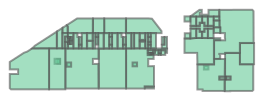

In [18]:
# Without tranformation
gc_raw = pg.load_geometrycollection_from_geojson(file_path)
gc_raw

In [ ]:
# With normalization
gc_norm, transform_parameters = pg.load_geojson(file_path)
print(
    f"Saved normalization parameters for inverse transformation : {transform_parameters}"
)
print(f"Loaded {len(gc_norm.geoms)} entities, total {gc_norm.length:.0f}m.")

Saved normalization parameters for inverse transformation : [626.8324607642935, 374.1259288328735, 1]
Loaded 95 entities, total 3594m.


## 2. How to load only segments form GeoJson?
[Back to top ↑](#how-to-)

Extract 504 unique segments (1 duplicates)


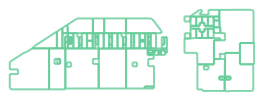

In [20]:
# Get segments in a geometry collection from a raw geojson file

gc_segments = pg.get_segments(file_path)
gc_segments

## 2. How to plot the plan in HD ?
[Back to top ↑](#how-to-)

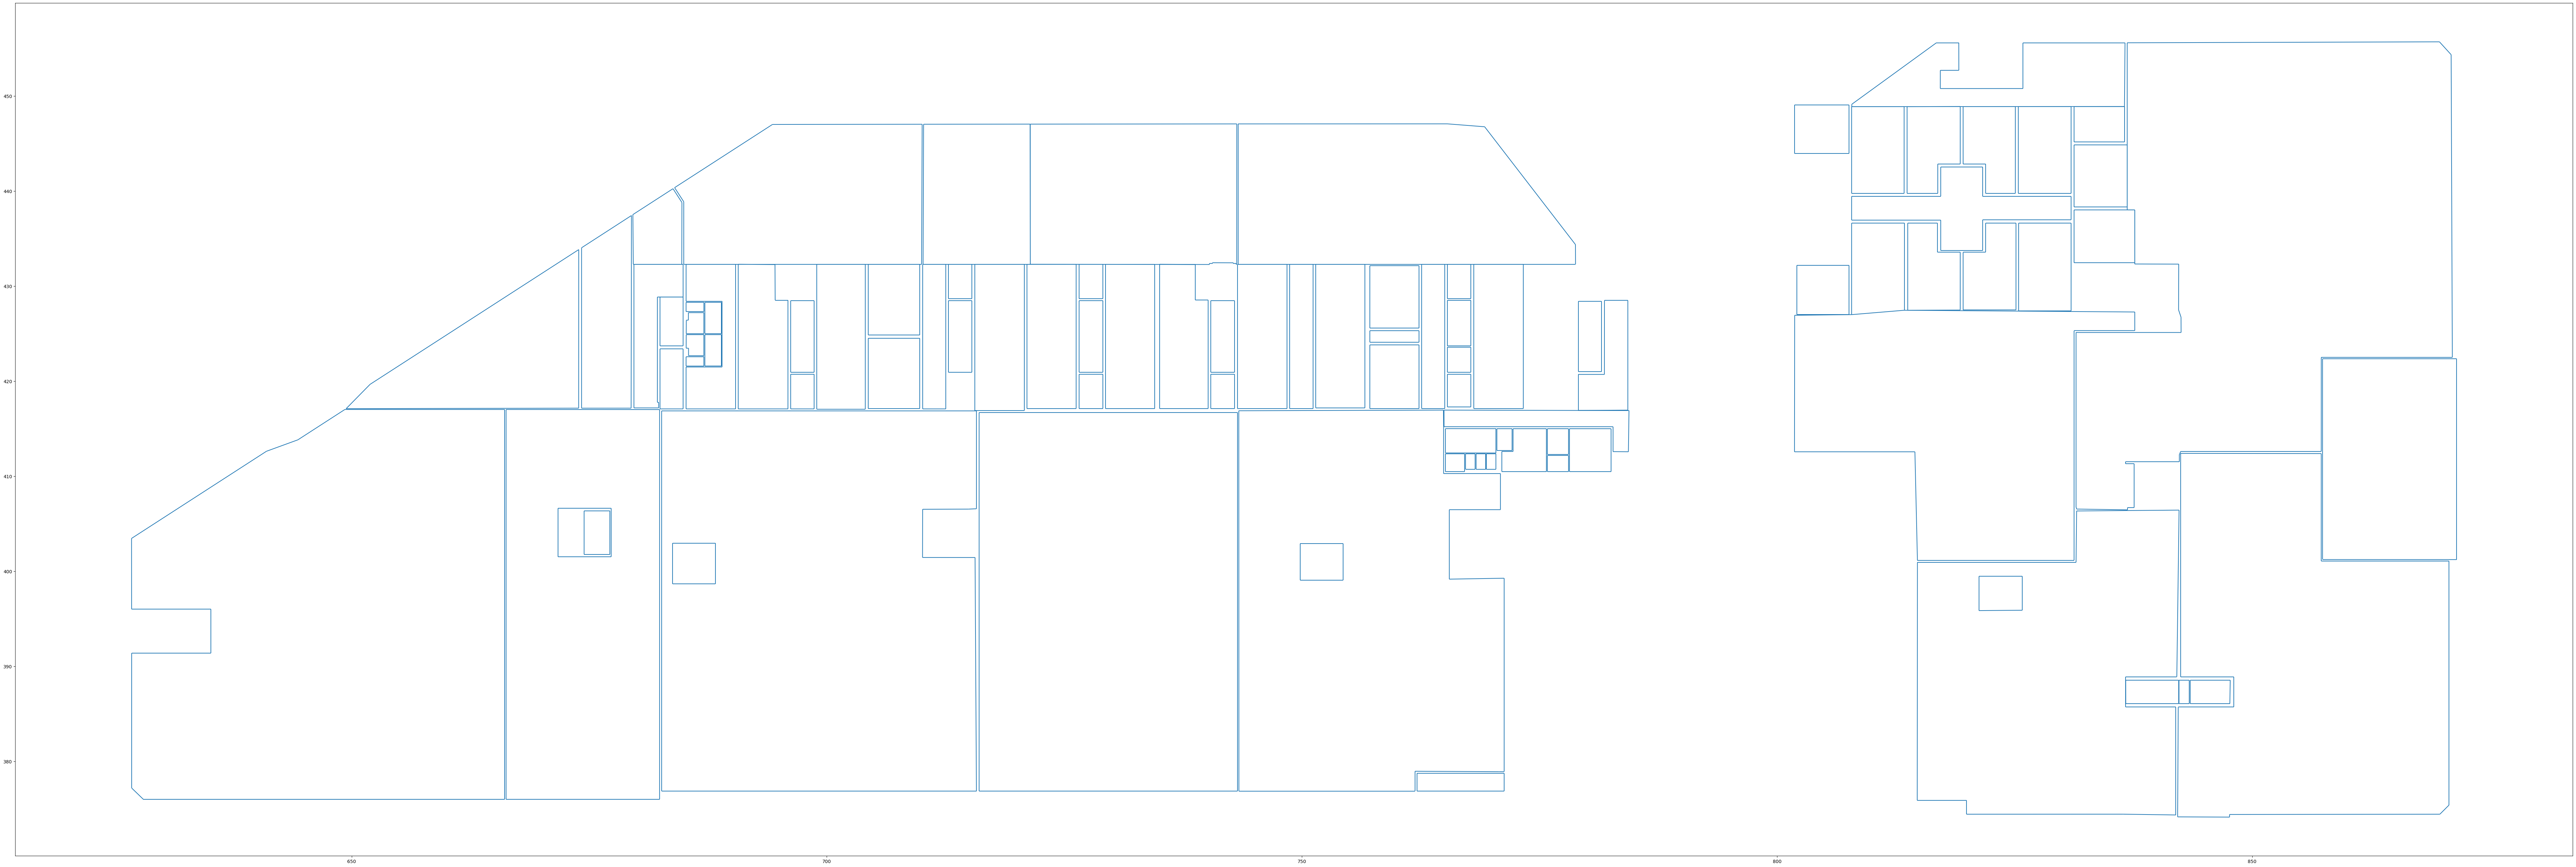

In [21]:
# H1: rise the definition
pg.plot_GeometryCollection(gc_segments, figsize=(100, 100))

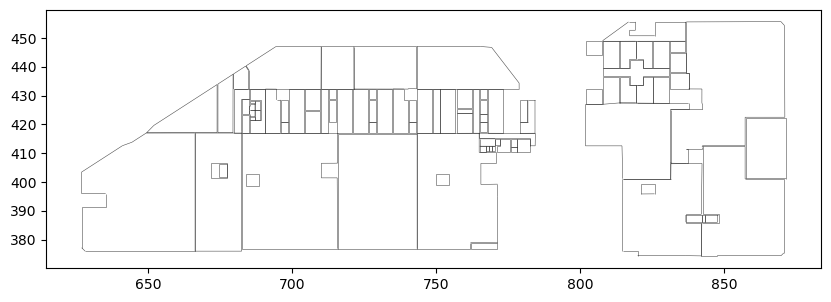

In [22]:
# H2: lower the linewidth. Other pyplot kwargs can be passed to geopandas.GeoSeries.plot
pg.plot_GeometryCollection(
    gc_segments, figsize=(10, 10), color="k", linewidth=0.4, alpha=0.7
)

## 3. How to iterate through the segments?

Segments are into stored into a shapely.GeometryCollection object that is 
iterable through the `gc.geoms` property.
[Back to top ↑](#how-to-)

In [23]:
# use the .geoms property that is iterable
print(type(gc_segments.geoms))

for segment in gc_segments.geoms:
    print(segment)
    # return the coordinates of the two points as ([x1, x2], [y1, y2])
    print(segment.xy)
    break
# >>> <class 'shapely.geometry.base.GeometrySequence'>
# >>> LINESTRING (3.4717383791561587 27.472680807304148, 3.5067598935479767 27.512141737399304)
# >>> (array('d', [3.4717383791561587, 3.5067598935479767]), array('d', [27.472680807304148, 27.512141737399304]))

<class 'shapely.geometry.base.GeometrySequence'>
LINESTRING (825.1389049033933 427.4811841473594, 825.1389049033933 436.6189242913465)
(array('d', [825.1389049033933, 825.1389049033933]), array('d', [427.4811841473594, 436.6189242913465]))


## 4. How to validate my model?

In [ ]:
# Chose a Spaces-Walls folder
validate_subfolder = Path(
    "data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres"
)
# Instantiate a model from the ./models folder
# Example with polygons
model = SegmentBasedClustering()
metric = average_matched_iou
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)
# Example with Computer vision
model = CVSegmentation()
score = test_model_on_sample(
    model, sample_folder=validate_subfolder, metric=metric
)
print(
    f"Score: {score:.3f} for {model.__name__} on folder "
    f"{validate_subfolder} in with "
    f"{metric.__name__}"
)

Extract 88 unique segments (0 duplicates)
Score: 0.800 for SegmentBasedClustering on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou
Extract 88 unique segments (0 duplicates)
Score: 0.879 for CVSegmentation(dpi:50, thickness:7, dilatation:gaussian on folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_D/Ecole Centrale - Bat D - Plan d'Çtage 00_2nd oeuvre fenetres in with average_matched_iou


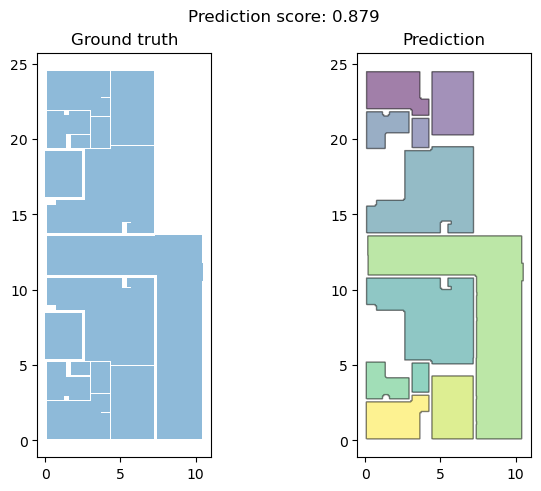

In [46]:
# Display the best IoU
fig, axs = plt.subplots(1, 2, layout="constrained")
# Ground Truth
axs[0].set_title("Ground truth")
geoms_true = pg.load_geometrycollection_from_geojson(
    validate_subfolder / "Spaces.geojson",
)
gpd.GeoSeries(geoms_true).plot(ax=axs[0], alpha=0.5)

# Predictions
x = pg.load_geometrycollection_from_geojson(
    validate_subfolder / "Walls.geojson",
)
y_pred = model(x)

y_pred_df = gpd.GeoDataFrame(
    y_pred.geoms,
    columns=["geometry"],
).reset_index()
y_pred_df.plot(ax=axs[1], alpha=0.5, column="index", edgecolor="black")
axs[1].set_title("Prediction")
axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())
score = average_matched_iou(geoms_true.geoms, y_pred.geoms)
plt.suptitle(f"Prediction score: {score:.3f}")
plt.show()

In [43]:
# Score on the whole validation set
data_folder = Path("data/spaces-walls/")
metric = average_matched_iou
model = SegmentBasedClustering()
score_model(model, data_folder, metric=metric)

SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce ne correspond aux critères de taille
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée
SBC: Aucune pièce fermée n'a été trouvée


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_ious)


Score: 0.635 for SegmentBasedClustering on folder data/spaces-walls in 294.20s with average_matched_iou


np.float64(0.634526479850683)

In [45]:
model = CVSegmentation()
score_model(model, data_folder, metric=metric)

ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - plan d'Çtage de faux plafonds 00b_NF: No segments found to generate binary image.
ValueError in folder data/spaces-walls/Ecole Centrale Thomas/ARC_BAT_E/Ecole Centrale - Bat E - Plan d'Çtage 00b_revet: No segments found to generate binary image.


/Users/tristanwaddington/Documents/Informatique/Git_reps/CapstoneContour/utils/metrics.py:105: RuntimeWarning: Mean of empty slice
  return np.nanmean(matched_ious)


Score: 0.761 for CVSegmentation(dpi:50, thickness:7, dilatation:gaussian on folder data/spaces-walls in 38.61s with average_matched_iou


np.float64(0.7605708268306369)